# Data Storytelling 
## Analyzing the Dance of Temperature and Rainfall in Agricultural Patterns

### Target objective: 
- Tell a compelling story about a dataset that interests me

## Dataset: Weather Observations from 2005 - 2010 from AgMERRA dataset

### Variables: 
- tmax (Maximum Temperature)
- tmin (Minimum Temperature)
- prate (Precipitation Rate)
- srad (Solar Radiation)
- wndspd (Wind Speed)
- rhstmax (Relative Humidity at Tmax)

# The Rhythms of the Sky: Unveiling the Dance of Weather and Agriculture

Imagine a world where every seed planted is a gamble, every harvest a game of chance. For millennia, farmers have looked to the skies, seeking signs and patterns that herald the times of sowing and reaping. Today, we stand on the shoulders of giants, wielding data as our guide through the seasons.

In this exploration, we delve into the heartbeats of our planet's weather patterns, decoding the whispers of the wind, the tales of the sun, and the dance of the rain — all through the lens of data. Our journey takes us through a dataset rich with insights, a tapestry woven from the threads of countless measurements, spanning temperatures, precipitation, solar radiation, and more.

Join us as we unravel the stories that this data tells, stories that are not just numbers and charts, but narratives vital to the pulse of agriculture and the sustenance of our societies.

**Question of interest**: *How have average temperatures and precipitation levels changed over the years?*

# Setting the Scene: The Ensemble of Elements

In this narrative, each weather variable is a character in our story, playing a crucial role in the drama of agriculture:

- **Temperature (tmax, tmin)**: The twin deities of heat, dictating the growth rhythms of crops.
- **Precipitation (prate)**: The life-bringer, whose abundance or absence can spell bounty or famine.
- **Solar Radiation (srad)**: The radiant energy, fueling photosynthesis — the very breath of plants.
- **Wind Speed (wndspd)**: The herald of change, shaping landscapes and turning the wheels of the climate.
- **Relative Humidity (rhstmax)**: The invisible presence, a silent partner to temperature, with a hand in the fates of drought and dew.

These actors do not perform in isolation; they are an ensemble, their interplay captured in the dataset we have chosen. Culled from the meticulous observations of the AgMERRA dataset, this information is a foundation upon which we can build understanding and prediction.


In [57]:
# Imports
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import cftime
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

To capture the full picture, we process each variable individually, iterating through the years 2005 to 2010. The data, stored in `.nc4` files, requires conversion from the native `cftime.DatetimeGregorian` format to `pandas` compatible `Timestamp` objects. This standardization of timestamps is crucial for the time-series analysis that follows.

The `process_variable` function orchestrates this transformation and prepares our dataset for analysis. It reads the files, converts the timestamps, averages the spatial data, and compiles the results into a comprehensive DataFrame for each variable. These DataFrames are then joined on their time index, yielding a unified dataset ready for exploration.

The resulting structure is a DataFrame with an index of `DatetimeIndex` type, confirming that our data is aptly time-aligned.

In [44]:
def convert_times(cftime_index):
    # Explicitly convert cftime.DatetimeGregorian objects to pandas Timestamp objects
    return pd.Index(pd.to_datetime([date.isoformat() for date in cftime_index]))

def process_variable(variable_name, years):
    df_list = []
    for year in years:
        file_path = f'dataset/AgMERRA_{year}_{variable_name}.nc4'
        dataset = nc.Dataset(file_path)

        # Using the correct time units format
        time_units = 'days since 1980-01-01 12:00:00'
        time_var = dataset['time']
        times = nc.num2date(time_var[:], units=time_units)

        # Convert cftime to datetime objects understandable by pandas
        times = convert_times(times)

        # Extract the data for the variable across all spatial points
        data = dataset.variables[variable_name][:]
        data_avg = np.mean(data, axis=(1, 2))  # Average across spatial dimensions

        # Convert to DataFrame and append to list
        df = pd.DataFrame(data_avg, index=times, columns=[variable_name])
        df_list.append(df)

        # Close the dataset after processing
        dataset.close()

    # Combine all DataFrames into one
    combined_df = pd.concat(df_list)
    return combined_df

# List of years to process
years = [2005, 2006, 2007, 2008, 2009, 2010]

# Process each variable and combine into a single DataFrame
# Repeat this for each variable you are interested in
tmax_df = process_variable('tmax', years)
tmin_df = process_variable('tmin', years)
prate_df = process_variable('prate', years)
srad_df = process_variable('srad', years)
wndspd_df = process_variable('wndspd', years)
rhstmax_df = process_variable('rhstmax', years)

# Now, combine all DataFrames by their index (time)
final_df = tmax_df.join(tmin_df).join(prate_df).join(srad_df).join(wndspd_df).join(rhstmax_df)

# Ensure final_df is sorted by index
final_df.sort_index(inplace=True)

print(type(final_df.index))  # Should output: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

# Check the combined DataFrame
print(final_df.head())

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
                         tmax      tmin     prate      srad    wndspd  \
2005-01-01 12:00:00  4.616451 -5.440598  1.615900  9.306351  2.764611   
2005-01-02 12:00:00  4.677034 -5.356628  1.685108  9.198634  2.864663   
2005-01-03 12:00:00  4.824372 -5.125763  1.941978  9.351749  2.955150   
2005-01-04 12:00:00  4.864802 -5.148127  1.974095  9.445088  2.817155   
2005-01-05 12:00:00  5.171516 -5.033779  1.826847  9.590463  2.832623   

                       rhstmax  
2005-01-01 12:00:00  40.046232  
2005-01-02 12:00:00  40.582473  
2005-01-03 12:00:00  40.172715  
2005-01-04 12:00:00  40.341839  
2005-01-05 12:00:00  40.689398  


In [45]:
final_df.describe()

,tmax,tmin,prate,srad,wndspd,rhstmax
count,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000
mean,14.706130,3.904916,1.983499,14.564558,2.457190,42.411266
std,7.155919,6.895985,0.319843,3.922564,0.234730,2.424437
min,2.284053,-7.768920,1.074761,8.745445,1.977991,35.103662
25%,7.490139,-3.008450,1.747609,10.697168,2.258291,40.598706
50%,15.314610,4.548197,1.935648,14.430129,2.436914,42.972504
75%,21.730554,10.634698,2.186231,18.520221,2.646204,44.379973
max,24.847591,13.910333,3.158922,20.838418,3.128024,46.611695


In [46]:
final_df.isnull().sum()

tmax       0
tmin       0
prate      0
srad       0
wndspd     0
rhstmax    0
dtype: int64

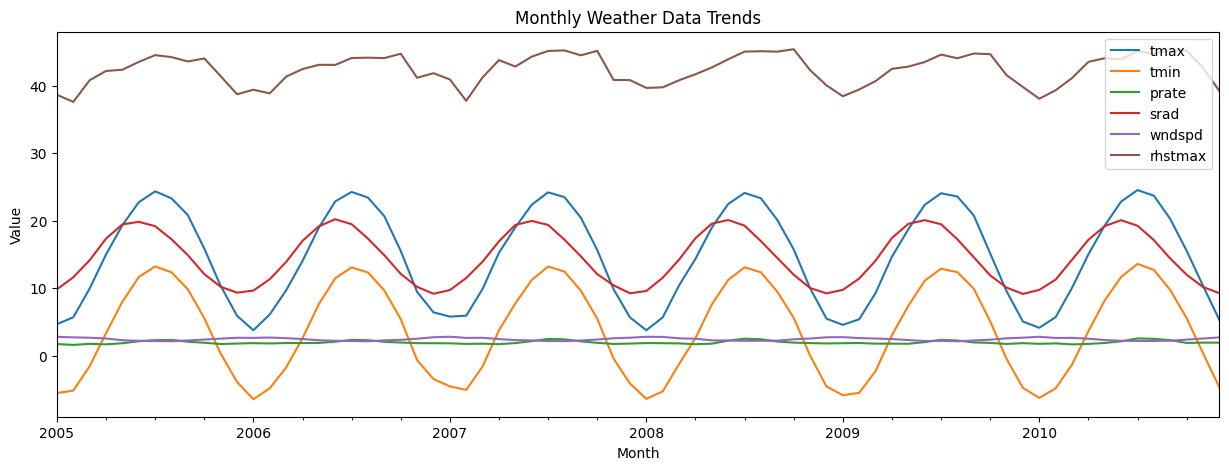

            tmax       tmin      prate       srad     wndspd    rhstmax
count  72.000000  72.000000  72.000000  72.000000  72.000000  72.000000
mean   14.662157   3.859437   1.981900  14.551294   2.458265  42.390983
std     7.107204   6.857405   0.238768   3.870816   0.213503   2.235974
min     3.784533  -6.423954   1.614616   9.166273   2.148267  37.593676
25%     8.580236  -2.549410   1.809193  11.069358   2.260297  40.811173
50%    15.215934   4.449015   1.892729  14.317122   2.464455  42.749727
75%    21.202537  10.222425   2.123020  17.880706   2.652449  44.237211
max    24.533859  13.607088   2.578684  20.216267   2.827457  45.387335


In [47]:
# Convert daily data to monthly, taking the mean for each month
monthly_df = final_df.resample('M').mean()

# Plotting the data
monthly_df.plot(figsize=(15, 5), title='Monthly Weather Data Trends')
plt.xlabel('Month')
plt.ylabel('Value')
plt.show()

# Displaying summary statistics
print(monthly_df.describe())

In [54]:
# Explore correlations between variables
print(monthly_df.corr())

             tmax      tmin     prate      srad    wndspd   rhstmax
tmax     1.000000  0.997302  0.759382  0.859730 -0.974575  0.882843
tmin     0.997302  1.000000  0.775638  0.826205 -0.978160  0.897440
prate    0.759382  0.775638  1.000000  0.524839 -0.760696  0.671312
srad     0.859730  0.826205  0.524839  1.000000 -0.797667  0.625663
wndspd  -0.974575 -0.978160 -0.760696 -0.797667  1.000000 -0.864463
rhstmax  0.882843  0.897440  0.671312  0.625663 -0.864463  1.000000


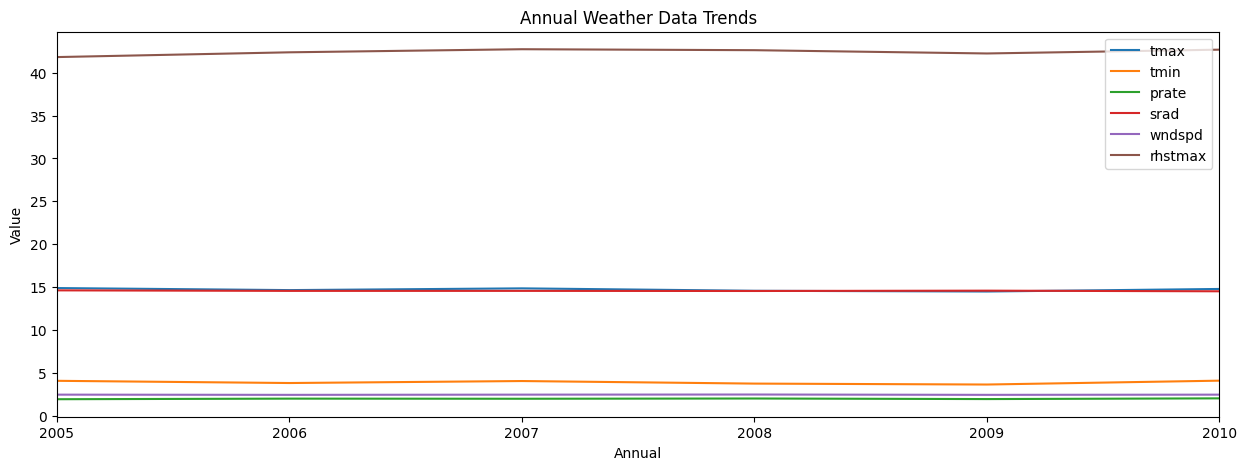

In [52]:
annual_df = final_df.resample('A').mean()

# Plotting the data
annual_df.plot(figsize=(15, 5), title='Annual Weather Data Trends')
plt.xlabel('Annual')
plt.ylabel('Value')
plt.show()

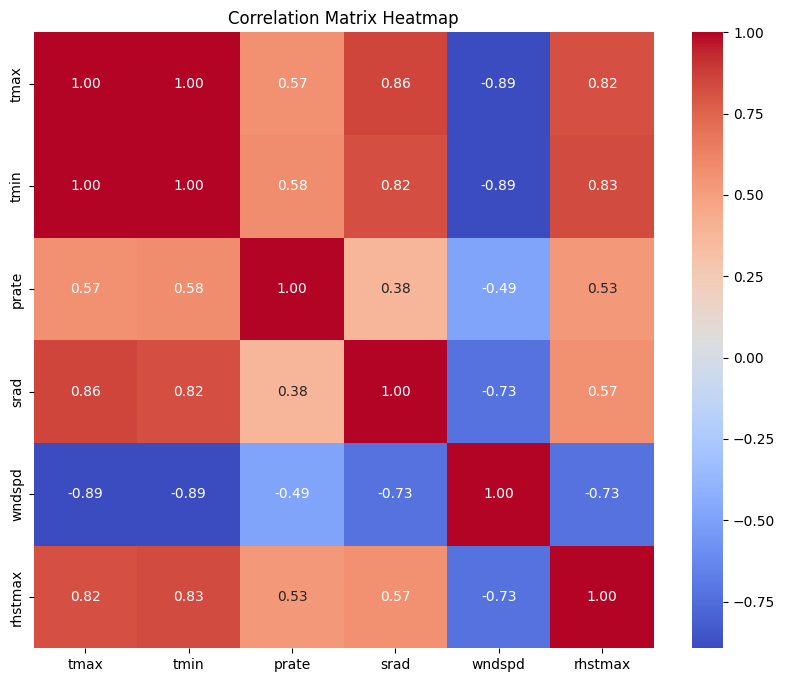

In [56]:
# Visualizing Correlation with a Heatmap

correlation_matrix = final_df.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

*Temperature Synergy*: Maximum and minimum temperatures moved in tandem, a duet of warmth and cold, reflecting the expected diurnal cycle.

*Precipitation and Warmth*: Precipitation showed a moderate positive relationship with temperature. On the days the sun burned brighter and the air was warmer, we observed a touch more rain.

*The Variable Winds*: Wind speed presented an inverse waltz with temperature. As the winds picked up their pace, they seemed to chase away the warmth.

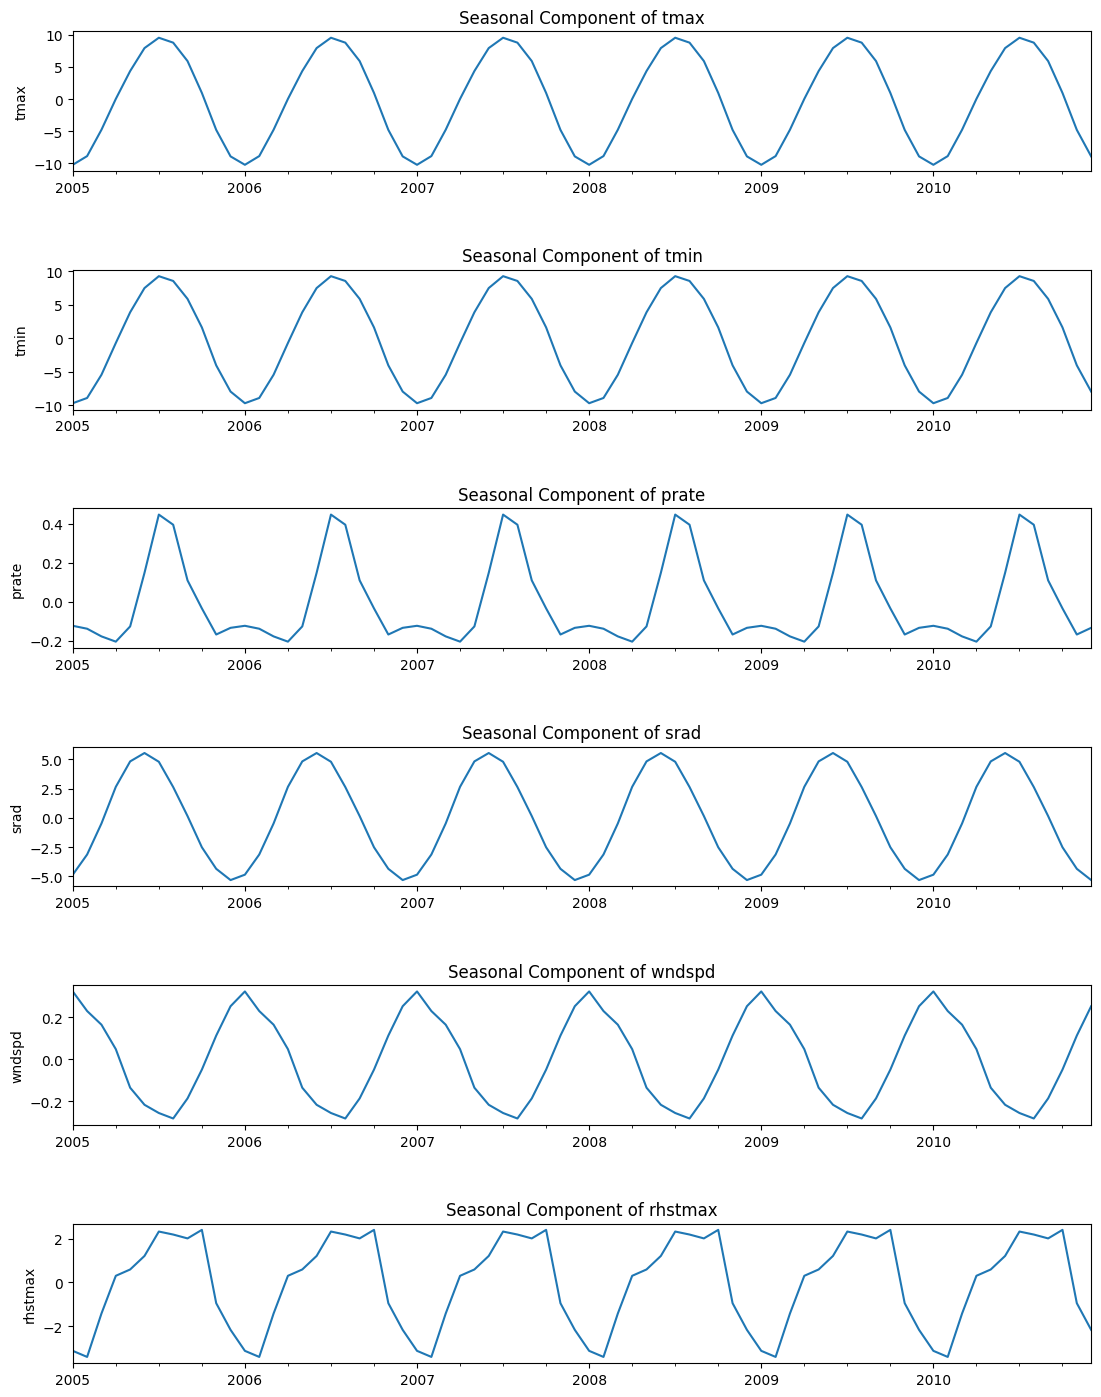

In [59]:
# Seasonal Analysis

variables = ['tmax', 'tmin', 'prate', 'srad', 'wndspd', 'rhstmax']  # list of variables

# Decompose and plot the seasonal component for each variable
fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize=(12, 15))
fig.tight_layout(pad=5.0)

for i, var in enumerate(variables):
    result = seasonal_decompose(monthly_df[var], model='additive', period=12)
    result.seasonal.plot(ax=axes[i], title=f'Seasonal Component of {var}')
    axes[i].set_ylabel(var)

plt.show()

Our seasonal decomposition revealed the rhythm of the variables over time:

**Temperature**: Displayed a wave-like pattern, cresting in the summer and troughing in winter.

**Precipitation**: Although it followed a seasonal beat, its tempo was less predictable, hinting at a complex interplay with other atmospheric actors.
    
**Solar Radiation**: Peaked with the height of summer, driving the crescendo of temperature highs.

**Wind Speed**: Often rose as temperatures fell, a counterpoint to the warmth.

**Relative Humidity**: Showed variations that suggested a relationship with both temperature and precipitation, essential factors for agricultural planning.

In [58]:
# Regression Analysis

# Preparing the independent variables (X) and dependent variable (y)
X = monthly_df[['srad', 'wndspd', 'prate', 'rhstmax']]  # Independent variables
y = monthly_df['tmax']  # Dependent variable

# Adding a constant to the model (for the intercept)
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit()

# Summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   tmax   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1046.
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           1.43e-59
Time:                        12:33:24   Log-Likelihood:                -93.465
No. Observations:                  72   AIC:                             196.9
Df Residuals:                      67   BIC:                             208.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2692      8.174      1.256      0.2

The OLS regression analysis offered a predictive melody, identifying how these variables may influence one another:

**Solar Influence**: The model underscored solar radiation's positive impact on temperature, a fact well-known to any farmer or gardener.

**Wind's Chilling Effect**: The significant negative coefficient for wind speed reinforced the cooling effect that wind can have.

**Statistical Harmony**: A high R-squared value indicated that our model captured much of the variability in temperature—a sign that our predictions might hold water.

**The Echoes of Autocorrelation**: The Durbin-Watson statistic hovered close to 2, suggesting that successive observations were not heavily dependent on their predecessors, an important consideration for the independence of measurements.

*Multicollinearity is signaled by a high condition number*. This suggests that there needs to be some model refinement to improve the model's relaibility. One of two things could be done here: dimensionality reduction techniques or variable selection methods.

## Analysis of Temperature and Precipitation Trends

### Temperature Trends
In analyzing both maximum (tmax) and minimum (tmin) temperature readings, I observed the expected oscillating patterns reflective of seasonal changes. To investigate a potential warming trend, I looked for year-over-year increases in these oscillations. However, within the six years of data examined, I did not find a consistent rise. Instead, there were normal fluctuations that did not conclusively indicate a warming or cooling trend.

### Precipitation Trends
Similar to temperature, I applied a comparable approach to scrutinize precipitation levels (prate). Overall, I observed a slight increase in precipitation rates year by year, although these changes were modest. While these subtle rises may suggest a trend, it's important to note that six years is a relatively short period to confirm long-term climatic shifts.

### Considerations for Trend Analysis
To make definitive statements on weather trends, it's typically necessary to assess data spanning several decades to distinguish long-term changes from short-term variability. While the analysis sheds light on short-term fluctuations and hints at an increase in precipitation, a more extended dataset would be essential for robust conclusions.

### Future Directions
Moving forward, I plan to continue tracking these variables, extending the dataset to allow for a more comprehensive trend analysis. It's through careful, sustained observation over an extended period that we can unravel the true narrative of our changing climate and its implications for our environment and agriculture.


In [67]:
# Calculate the annual mean temperatures
annual_temp_mean = final_df[['tmax', 'tmin']].resample('A').mean()

# Calculate the annual total precipitation
print('annual_precip_total')
annual_precip_total = final_df['prate'].resample('A').sum()

annual_temp_mean, annual_precip_total

annual_precip_total


(                 tmax      tmin
 2005-12-31  14.889661  4.075493
 2006-12-31  14.651375  3.817914
 2007-12-31  14.853678  4.049537
 2008-12-31  14.571299  3.750952
 2009-12-31  14.486963  3.642870
 2010-12-31  14.784173  4.093149,
 2005-12-31    704.231831
 2006-12-31    729.166728
 2007-12-31    724.045879
 2008-12-31    736.737165
 2009-12-31    710.540567
 2010-12-31    741.123056
 Freq: A-DEC, Name: prate, dtype: float64)

## Analysis of Annual Mean Temperatures and Total Precipitation

### Annual Mean Temperatures
- The average maximum temperature (tmax) and average minimum temperature (tmin) exhibit fluctuations from year to year without a clear upward or downward trend.
- These variations suggest natural inter-annual variability rather than a definitive warming or cooling trend over the six-year period.

### Annual Total Precipitation
- Precipitation levels, measured by the precipitation rate (prate), show minor year-to-year increases.
- While these increases are not substantial, they imply a gradual rise in annual precipitation during the analyzed period.

### Considerations for Climate Trend Analysis
- The short duration of the dataset makes it challenging to draw definitive conclusions about long-term climate trends such as global warming.
- Understanding climate changes typically requires examining data over much longer periods to account for various natural factors that can cause short-term fluctuations.

### Conclusions
- While slight increases in precipitation were noted, the temperature data does not indicate a significant warming or cooling trend within the six-year timeframe.
- Extending the dataset to include more years would be crucial for more robust conclusions that could impact agricultural planning and environmental policy.
- A longer temporal scope would help differentiate between short-lived weather phenomena and sustained climatic shifts.
